In [12]:
import numpy as np
from TDD.TDD import Index,get_int_key,get_unique_table,get_identity_tdd,get_count,tdd_2_np
from TDD.TDD import Ini_TDD,TDD,diag_matrix_2_TDD,cnot_2_TDD,Slicing,cont,Single_qubit_gate_2TDD,diag_matrix_2_TDD2
from TDD.TDD_show import TDD_show,TDD_show2
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
import time
import datetime
import copy
import pandas as pd
from func_timeout import func_set_timeout
import func_timeout

In [13]:
def is_diagonal(U):
    i, j = np.nonzero(U)
    return np.all(i == j)

def add_hyper_index(var_list,hyper_index):
    for var in var_list:
        if not var in hyper_index:
            hyper_index[var]=0
            
def add_index_2_node(var_list,node,index_2_node):
    for var in var_list:
        if not var in index_2_node:
            index_2_node[var]=set([node])
        else:
            index_2_node[var].add(node)

def add_index_set(var_list,index_set):
    for var in var_list:
        index_set.add(var)

In [14]:
def get_tensor_index(cir):
    """return the dict that link every quantum gate to the corresponding index"""

    node_2_index=dict()
    index_2_node=dict()
    index_set=set()
    hyper_index=dict()
    qubits_index = dict()
    for k in range(len(cir._qubits)):
        qubits_index[k]=0
    gates=cir.data
    for k in range(len(gates)):
        g=gates[k]
        nam=g[0].name
        q = [q.index for q in g[1]]
        gate_qubits=len(q)
        if nam=='cx':
            var_con='x'+ str(q[0])+str(0)+str(qubits_index[q[0]])
            var_tar_in='x'+ str(q[1])+str(0)+str(qubits_index[q[1]])
            var_tar_out='x'+ str(q[1])+str(0)+str(qubits_index[q[1]]+1)
            add_hyper_index([var_con,var_tar_in,var_tar_out],hyper_index)  
            node_2_index[k]=[Index(var_con,hyper_index[var_con]),Index(var_con,hyper_index[var_con]+1),Index(var_con,hyper_index[var_con]+2),Index(var_tar_in,hyper_index[var_tar_in]),Index(var_tar_out,hyper_index[var_tar_out])]
            hyper_index[var_con]+=2
            qubits_index[q[1]]+=1
            add_index_2_node([index.key for index in node_2_index[k]],k,index_2_node)
            add_index_set([index.key for index in node_2_index[k]],index_set)   
            continue
            
        if gate_qubits==1:
            q=q[0]
            var_in='x'+ str(q)+str(0)+str(qubits_index[q])
            var_out='x'+ str(q)+str(0)+str(qubits_index[q]+1)
            add_hyper_index([var_in,var_out],hyper_index)
            u_matrix=Operator(g[0]).data
            if is_diagonal(u_matrix):
                node_2_index[k]=[Index(var_in,hyper_index[var_in]),Index(var_in,hyper_index[var_in]+1)]
                hyper_index[var_in]+=1
                index_set.add(var_in)
                add_index_2_node([index.key for index in node_2_index[k]],k,index_2_node)
                add_index_set([index.key for index in node_2_index[k]],index_set)
                continue
            else:
                node_2_index[k]=[Index(var_in,hyper_index[var_in]),Index(var_out,hyper_index[var_out])]
                qubits_index[q]+=1
                add_index_2_node([index.key for index in node_2_index[k]],k,index_2_node)
                add_index_set([index.key for index in node_2_index[k]],index_set)
                continue
        if gate_qubits==2:
            var_con_in='x'+ str(q[0])+str(0)+str(qubits_index[q[0]])
            var_con_out='x'+ str(q[0])+str(0)+str(qubits_index[q[0]]+1)
            var_tar_in='x'+ str(q[1])+str(0)+str(qubits_index[q[1]])
            var_tar_out='x'+ str(q[1])+str(0)+str(qubits_index[q[1]]+1)
            add_hyper_index([var_con_in,var_con_out,var_tar_in,var_tar_out],hyper_index)
            u_matrix=Operator(g[0]).data
            if is_diagonal(u_matrix):
                node_2_index[k]=[Index(var_con_in,hyper_index[var_con_in]),Index(var_con_in,hyper_index[var_con_in]+1),Index(var_tar_in,hyper_index[var_tar_in]),Index(var_tar_in,hyper_index[var_tar_in]+1)]
                hyper_index[var_con_in]+=1
                hyper_index[var_tar_in]+=1
                add_index_2_node([index.key for index in node_2_index[k]],k,index_2_node)
                add_index_set([index.key for index in node_2_index[k]],index_set)
                continue
            else:
                node_2_index[k]=[Index(var_con_in,hyper_index[var_con_in]),Index(var_con_out,hyper_index[var_con_out]),Index(var_tar_in,hyper_index[var_tar_in]),Index(var_tar_out,hyper_index[var_tar_out])]
                qubits_index[q[0]]+=1
                qubits_index[q[1]]+=1
                add_index_2_node([index.key for index in node_2_index[k]],k,index_2_node)
                add_index_set([index.key for index in node_2_index[k]],index_set)
                continue

    for k in range(len(cir._qubits)):
        last1='x'+str(k)+str(0)+str(qubits_index[k])
        new1='y'+str(k)
        last2='x'+str(k)+str(0)+str(0)
        new2='x'+str(k)
        if qubits_index[k]!=0:
            index_set.remove(last1)
            index_set.add(new1)
            index_set.remove(last2)
            index_set.add(new2)
            index_2_node[new1]=index_2_node[last1]
            index_2_node[new2]=index_2_node[last2]
            index_2_node.pop(last1)
            index_2_node.pop(last2)
        elif last1 in index_set:
            index_set.remove(last1)
            index_set.add(new1)
            index_2_node[new1]=index_2_node[last1]
            index_2_node.pop(last1)
        for m in node_2_index:
            node_2_index[m]=[Index(new1,item.idx) if item.key ==last1 else item for item in node_2_index[m]]
            node_2_index[m]=[Index(new2,item.idx) if item.key ==last2 else item for item in node_2_index[m]]
            
    return node_2_index,index_2_node,index_set

In [15]:
def get_tdd(gate,index_list):
    """get the TDD of a quantum gate"""
    nam=gate[0].name
    u_matrix=Operator(gate[0]).data
    q = [q.index for q in gate[1]]
    gate_qubits=len(q)
    if gate_qubits ==1:
        if is_diagonal(u_matrix):
            return diag_matrix_2_TDD(u_matrix,index_list)
        else:
            return Single_qubit_gate_2TDD(u_matrix,index_list)
    if nam =='cx':
            return cnot_2_TDD(index_list,case=1)
    if gate_qubits ==2:
        if is_diagonal(u_matrix):
            return diag_matrix_2_TDD2(u_matrix,index_list)
        else:
            return Two_qubit_gate_2TDD(u_matrix,index_list)        

In [16]:
def get_tdd_of_a_part_circuit(cir,involve_nodes,node_2_index):
    """get the TDD of a part of circuit"""
    tdd=get_identity_tdd()
    max_node_num = 0
    
    gates=cir.data
    
    for k in involve_nodes:
        temp_tdd=get_tdd(gates[k],node_2_index[k])
        tdd=cont(tdd,temp_tdd)
        max_node_num=max(max_node_num,tdd.node_number())
    return tdd,max_node_num

In [17]:
def circuit_partion1(cir,cx_max,qubits_reorder=False):
    """The first partition scheme; 
    cx_max is the number of CNOTs allowed to be cut
    """
    res=[[[],[]]]
    cx_num=0
    level=0
    
    num_qubit=get_real_qubit_num(cir)
        
    qubits = []    
    qubits.append([k for k in range(num_qubit//2)])
    qubits.append([k for k in range(num_qubit//2,num_qubit)])

    gates=cir.data
    for k in range(len(gates)):
        g=gates[k]
        q = [q.index for q in g[1]]
        if len(q)==1:
            if q[0] in qubits[0]:
                res[level][0].append(k)
            else:
                res[level][1].append(k)
        elif len(q)==2:
            if q[0] in qubits[0] and q[1] in qubits[0]:
                res[level][0].append(k)
            elif q[0] in qubits[1] and q[1] in qubits[1]:
                res[level][1].append(k)
            else:
                cx_num+=1
                if cx_num<=cx_max:
                    if q[1] in qubits[0]:
                        res[level][0].append(k)
                    else:
                        res[level][1].append(k)
                else:
                    level+=1
                    res.append([])
                    res[level].append([])
                    res[level].append([])
                    if q[1] in qubits[0]:
                        res[level][0].append(k)
                    else:
                        res[level][1].append(k)
                    cx_num=1
        else:
            print("Not supported yet!!!")
            
    print('circuit blocks:',2*(level+1))
    return res

In [18]:
def circuit_partion2(cir,cx_max,c_part_width,qubits_reorder=False):
    """The second partition scheme
    cx_max is the number of CNOT that allowed to be cut
    c_part_width is the allowed qubit numbers of the C part;
    """
    res=[[[],[],[]]]
    cx_num=0
    level=0
    num_qubit=get_real_qubit_num(cir) 
    
    qubits=[]
    qubits.append([k for k in range(num_qubit//2)])
    qubits.append([k for k in range(num_qubit//2,num_qubit)])
    qubits.append([])
    c_range=[num_qubit,0]
    gates=cir.data
    for k in range(len(gates)):
        g=gates[k]
        q = [q.index for q in g[1]]
        if len(q)==1:
            if q[0] in qubits[0]:
                res[level][0].append(k)
            elif q[0] in qubits[1]:
                res[level][1].append(k)
            else:
                res[level][2].append(k)
        elif len(q)==2:
            if q[0] in qubits[0] and q[1] in qubits[0]:
                res[level][0].append(k)
            elif q[0] in qubits[1] and q[1] in qubits[1]:
                res[level][1].append(k)
            elif q[0] in qubits[2] and q[1] in qubits[2]:
                res[level][2].append(k)
            else:
                if cx_num < cx_max:
                    cx_num+=1
                    if q[1] in qubits[0]:
                        res[level][0].append(k)
                    else:
                        res[level][1].append(k)
                else:
                    c_width=max(c_range[1],max(q))-min(c_range[0],min(q))+1
                    if c_width<c_part_width:
                        res[level][2].append(k)
                        c_range[0]=min(c_range[0],min(q))
                        c_range[1]=max(c_range[1],max(q))
                        qubits[0]=[k for k in range(0,c_range[0])]
                        qubits[1]=[k for k in range(c_range[1]+1,num_qubit)]
                        qubits[2]=[k for k in range(c_range[0],c_range[1]+1)]
                    else:
                        level+=1
                        res.append([])
                        res[level].append([])
                        res[level].append([])
                        res[level].append([])
                        qubits.clear()
                        qubits.append([k for k in range(num_qubit//2)])
                        qubits.append([k for k in range(num_qubit//2,num_qubit)])
                        qubits.append([])
                        c_range=[num_qubit,0]
                        if q[0] in qubits[0] and q[1] in qubits[0]:
                            res[level][0].append(k)
                            cx_num=0
                        elif q[0] in qubits[1] and q[1] in qubits[1]:
                            res[level][1].append(k)
                            cx_num=0
                        else:
                            if q[1] in qubits[0]:
                                res[level][0].append(k)
                            else:
                                res[level][1].append(k)
                            cx_num=1
    print('circuit blocks:',3*(level+1))
    return res

In [19]:
@func_set_timeout(3600)
def Simulation_with_cir_partion(cir,partion_scheme=0,cx_max=2,c_part_width=2):
    """Simulate a circuit with TDD;
    cir is a qiskit quantum circuit;
    partition_scheme = 0, 1, 2
    cx_max is the number of CNOT that allowed to be cut in two partition scheme
    c_part_width is the allowed qubit numbers of the C part in the second partition scheme;
    return the result tdd and other corresponding information
    """
    max_idx=len(cir.data)
    var_order=[]
    for k in range(len(cir._qubits)-1,-1,-1):
        q_idx='y'+str(k)
        var_order.append(q_idx)
        for k1 in range(max_idx-1,-1,-1):
            q_idx='x'+str(k)+str(0)+str(k1)
            var_order.append(q_idx)
        q_idx='x'+str(k)
        var_order.append(q_idx)
    Ini_TDD(var_order)
    
    node_2_index,index_2_node,index_set = get_tensor_index(cir)
    
    max_node_num = 0
    tdd = get_identity_tdd()
    
    if partion_scheme==0:
        involve_nodes=list(range(len(cir.data)))
        tdd,max_node_num = get_tdd_of_a_part_circuit(cir,involve_nodes,node_2_index)
        return tdd, max_node_num
    
    if partion_scheme==1:
        partion_cir=circuit_partion1(cir,cx_max)
        for level in range(len(partion_cir)):
            tdd1,node_num1=get_tdd_of_a_part_circuit(cir,partion_cir[level][0],node_2_index)
            max_node_num = max(max_node_num,node_num1)
            tdd2,node_num2=get_tdd_of_a_part_circuit(cir,partion_cir[level][1],node_2_index)
            max_node_num = max(max_node_num,node_num2)
            temp_tdd=cont(tdd1,tdd2)
            max_node_num = max(max_node_num,temp_tdd.node_number())
            tdd=cont(tdd,temp_tdd)
            max_node_num = max(max_node_num,tdd.node_number())
        return tdd, max_node_num
    
    if partion_scheme==2:
        partion_cir=circuit_partion2(cir,cx_max,c_part_width)
        for level in range(len(partion_cir)):
            tdd1,node_num1=get_tdd_of_a_part_circuit(cir,partion_cir[level][0],node_2_index)
            max_node_num = max(max_node_num,node_num1)
            tdd2,node_num2=get_tdd_of_a_part_circuit(cir,partion_cir[level][1],node_2_index)
            max_node_num = max(max_node_num,node_num2)
            temp_tdd=cont(tdd1,tdd2)
            max_node_num = max(max_node_num,temp_tdd.node_number())
            tdd3,node_num3=get_tdd_of_a_part_circuit(cir,partion_cir[level][2],node_2_index)
            max_node_num = max(max_node_num,node_num3)
            temp_tdd=cont(tdd3,temp_tdd)
            max_node_num = max(max_node_num,temp_tdd.node_number())
            tdd=cont(tdd,temp_tdd)
            max_node_num = max(max_node_num,tdd.node_number())
        return tdd,max_node_num

In [20]:
def Simulation_with_time_out(cir,partion_scheme=0,cx_max=2,c_part_width=2):
    """set time out, use the package func_timeout """
    try:
        return Simulation_with_cir_partion(cir, partion_scheme,cx_max,c_part_width)
    except:
        print('Time out!')
        tdd = get_identity_tdd()
        return tdd,0

In [21]:
def get_real_qubit_num(cir):
    """Calculate the real number of qubits of a circuit"""
    gates=cir.data
    q=0
    for k in range(len(gates)):
        q=max(q,max([qbit.index for qbit in gates[k][1]]))
    return q+1

def get_gates_number(cir):
    """Calculate the real number of gates of a circuit"""
    return len(cir.data)

circuit: ex-1_166.qasm
qubits: 3
gates number: 19
run_time: 0.029924869537353516
max_node_num: 22
final nodes: 17


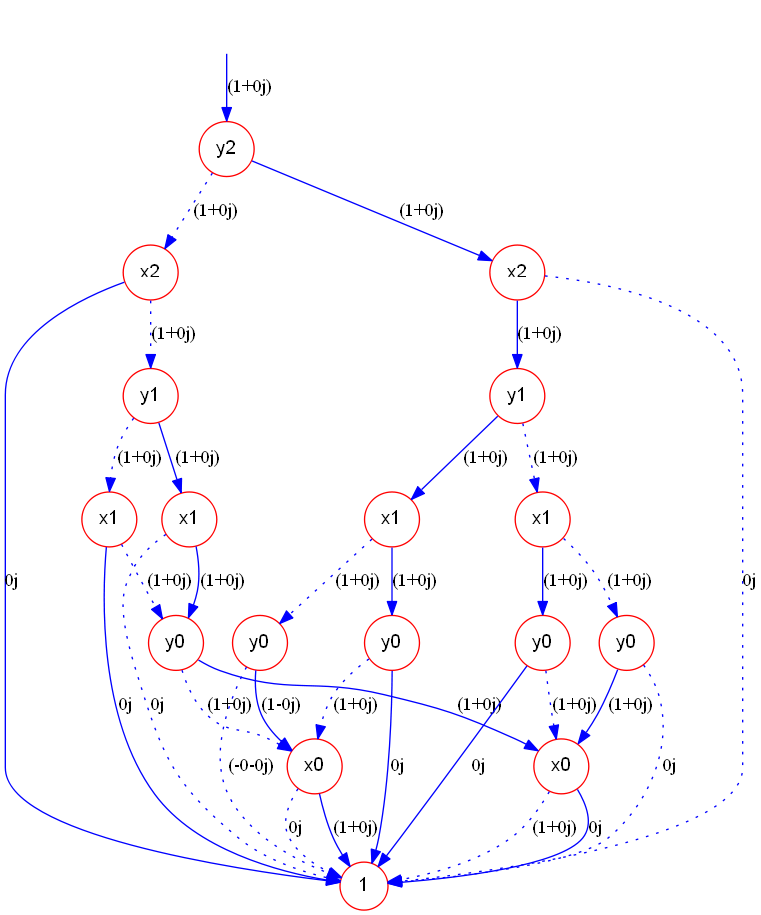

In [23]:
#Create a circuit and do simulation
path='Benchmarks/'
file_name="ex-1_166.qasm"
cir=QuantumCircuit.from_qasm_file(path+file_name)

print('circuit:',file_name)
num_qubit=get_real_qubit_num(cir)
print('qubits:',num_qubit)
print('gates number:',get_gates_number(cir))

t_start = time.time()
tdd,max_node_num=Simulation_with_cir_partion(cir, partion_scheme=0,cx_max=num_qubit//2,c_part_width=num_qubit//2+1)
run_time=time.time()-t_start
print('run_time:',run_time)
print('max_node_num:',max_node_num)
print('final nodes:',tdd.node_number())
TDD_show2(tdd)